In [1]:
using Turing
using Distances
using PyPlot
using Random
using LinearAlgebra
using LimberJack
using Interpolations

In [47]:
# Squared-exponential covariance function
sqexp_cov_fn(D, phi) = @.(exp(-D^2 / (2*phi))) + 0.0005 * LinearAlgebra.I
# Exponential covariance function
exp_cov_fn(D, phi) = @.(exp(-D / phi)) + 0.0005 * LinearAlgebra.I

exp_cov_fn (generic function with 1 method)

In [52]:
@model function latent_GP(y, X, data_cov; cov_fn=sqexp_cov_fn, cosmology=Cosmology())
    # Dimensions of predictors .
    N, P = size(X)
    gp_x = Vector(0:0.3:7)
    gp_N = length(gp_x)
    Q = N + gp_N
    Z = [X; gp_x]
    # Distance matrix.
    D = pairwise(Distances.Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    Dz_gp = cosmology.Dz(vec(gp_x))
    
    # Priors.
    mu ~ MvNormal(zeros(gp_N), ones(gp_N))
    phi ~ LogNormal(0, 1)
    
    # Realized covariance function
    K = cov_fn(D, phi) 
    Koo = K[(N+1):end, (N+1):end] # GP-GP cov
    Koo_inv = inv(Koo)            
    Knn = K[1:N, 1:N] + data_cov  # Data-Data cov
    Kno = K[1:N, (N+1):end]       # Data-GP cov
    C = Kno * Koo_inv
    m = C * (Dz_gp .* (1 .+ mu)) + (y - Dz)
    S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
    gp ~ MvNormal(m, S)
    y = gp 
end

latent_GP (generic function with 1 method)

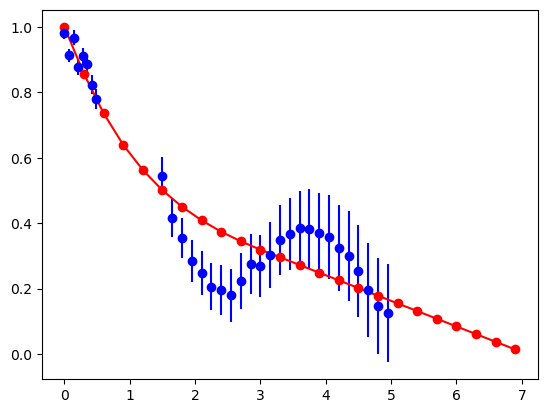

1-element Vector{PyCall.PyObject}:
 PyObject <matplotlib.lines.Line2D object at 0x7f4a05ca6d00>

In [53]:
cosmology = Cosmology()
data_1_x = Vector(0:0.07:0.5) 
data_2_x = Vector(1.5:0.15:5)
data_x = zeros(length(data_1_x)+length(data_2_x), 1)
data_x[1:length(data_1_x), 1] = data_1_x
data_x[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = data_2_x
N = length(data_x)

data = similar(vec(data_x))
data[1:length(data_1_x), 1] = cosmology.Dz(vec(data_1_x)) .* (1 .+ randn(length(data_1_x)) .* 0.03)
data[length(data_1_x)+1:length(data_1_x)+length(data_2_x), 1] = cosmology.Dz(vec(data_2_x)) .* (1 .+ 0.5 .* (sin.(vec(data_2_x)./0.5) + randn(length(data_2_x)) * 0.1))
#data = cosmology.Dz(vec(data_x)) .* (1 .+ 0.5 .* (sin.(vec(data_x)./0.5) + randn(N) * 0.1))
data_err = vec(@.((0.02 * data) + (0.03 * vec(data_x))))
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo")
gp_x = Vector(0:0.3:7)
gp_N = length(gp_x)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "ro-")

In [54]:
data_cov = zeros(N, N)
for i in 1:N
    data_cov[i,i] = data_err[i]^2 
end

In [55]:
chain = sample(latent_GP(data, data_x, data_cov), HMC(0.01, 100), 200)

Sampling: 100%|█████████████████████████████████████████| Time: 0:02:16


Chains MCMC chain (200×66×1 Array{Float64, 3}):

Iterations        = 1:1:200
Number of chains  = 1
Samples per chain = 200
parameters        = gp[1], gp[2], gp[3], gp[4], gp[5], gp[6], gp[7], gp[8], gp[9], gp[10], gp[11], gp[12], gp[13], gp[14], gp[15], gp[16], gp[17], gp[18], gp[19], gp[20], gp[21], gp[22], gp[23], gp[24], gp[25], gp[26], gp[27], gp[28], gp[29], gp[30], gp[31], gp[32], mu[1], mu[2], mu[3], mu[4], mu[5], mu[6], mu[7], mu[8], mu[9], mu[10], mu[11], mu[12], mu[13], mu[14], mu[15], mu[16], mu[17], mu[18], mu[19], mu[20], mu[21], mu[22], mu[23], mu[24], phi
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, n_steps, nom_step_size, step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse        ess      rhat 
      Symbol   Float64   Float64    Float64   Float64    Float64   Float64 

       gp[1]    0.8634    0.9012     0.0637    0.3150     7.9835    1.1257
       gp[2]    0.9065    0.69

┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364
┌ Warning: timestamp of type Missing unknown
└ @ MCMCChains /home/jaime/.julia/packages/MCMCChains/kWf0l/src/chains.jl:364


In [93]:
gp = group(chain, :gp).value.data[:, :, 1]
gp_m = vec(mean(gp, dims=1))
gp_s = vec(std(gp, dims=1));

In [104]:
mu = group(chain, :mu).value.data[:, :, 1]
mu_m = vec(mean(mu, dims=1))
mu_s = vec(std(mu, dims=1));

In [94]:
mu = group(chain, :mu).value.data[:, :, 1]
phi = group(chain, :phi).value.data[:, :, 1];

In [110]:
function make_gp_predict_fn(Xnew, y, X, cov_fn, data_cov, cosmology=Cosmology())
    N = size(X, 1)
    M = size(Xnew, 1)
    Q = N + M
    Z = [Xnew; X]
    D = pairwise(Euclidean(), Z, dims=1)
    Dz = cosmology.Dz(vec(X))
    new_Dz = cosmology.Dz(vec(Xnew))
    return (mu, phi) -> let
        K = cov_fn(D, phi) 
        K[(M+1):end, (M+1):end] = K[(M+1):end, (M+1):end] + data_cov
        Koo_inv = inv(K[(M+1):end, (M+1):end])
        Knn = K[1:M, 1:M]
        Kno = K[1:M, (M+1):end]
        C = Kno * Koo_inv
        m = C * (y - mu.*Dz) + mu.*new_Dz
        S = Matrix(LinearAlgebra.Hermitian(Knn - C * Kno'))
        mvn = MvNormal(m, S)
        rand(mvn)
    end
end

make_gp_predict_fn (generic function with 2 methods)

In [111]:
Xnew = gp_x #sort(randn(N, 1) * 4, dims=1)
gp_predict = make_gp_predict_fn(Xnew, data, data_x, sqexp_cov_fn, data_cov)
ynew = [gp_predict(mu[m], phi[m]) for m in 1:length(phi)]
ynew = hcat(ynew...);

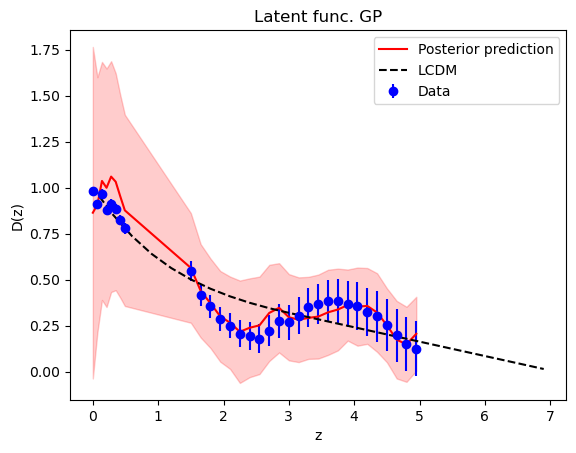

In [102]:
plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(data_x), gp_m, "r-",
         label="Posterior prediction")
plt.fill_between(vec(data_x), gp_m .+ gp_s,
                 gp_m .- gp_s, color="red",
                 alpha=0.2)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "k--", label="LCDM")
plt.xlabel("z")
plt.ylabel("D(z)")
plt.title("Latent func. GP")
plt.legend()
#plt.legend(loc="lower right")
#plt.title("GP Posterior predictive with 95% credible interval");

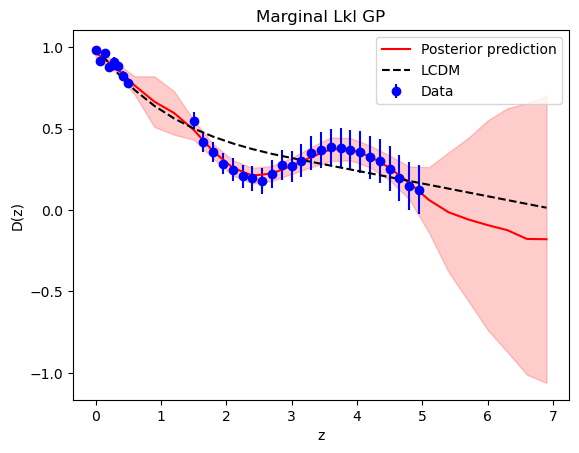

In [112]:
pred_mean = mean(ynew, dims=2)
pred_std = std(ynew, dims=2)

plt.errorbar(vec(data_x), data, yerr=data_err, fmt="bo", label="Data")
plt.plot(vec(Xnew), vec(pred_mean), color="red",
         label="Posterior prediction")
plt.fill_between(vec(Xnew), vec(pred_mean .+ pred_std),
                 vec(pred_mean .- pred_std), color="red",
                 alpha=0.2)
plt.plot(gp_x, cosmology.Dz(gp_x) .* ones(gp_N), "k--", label="LCDM")
plt.xlabel("z")
plt.ylabel("D(z)")
plt.title("Marginal Lkl GP")
plt.legend()
#plt.legend(loc="lower right")
#plt.title("GP Posterior predictive with 95% credible interval");